In [1]:
!pip install -q tensorflow-gpu==2.0.0-alpha0

     |████████████████████████████████| 332.1MB 59kB/s 
     |████████████████████████████████| 419kB 45.0MB/s 
     |████████████████████████████████| 3.0MB 42.1MB/s 
     |████████████████████████████████| 61kB 27.7MB/s 


In [0]:
import tensorflow as tf

In [3]:
tf.__version__

'2.0.0-alpha0'

In [0]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import pathlib

from IPython import display

In [0]:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/

In [6]:
!kaggle datasets download -d jessicali9530/celeba-dataset

 99% 1.20G/1.21G [00:09<00:00, 184MB/s]
100% 1.21G/1.21G [00:09<00:00, 133MB/s]


In [0]:
!unzip -q celeba-dataset.zip 

In [0]:
!unzip -q img_align_celeba.zip

In [9]:
!ls

celeba-dataset.zip    list_attr_celeba.csv     list_landmarks_align_celeba.csv
img_align_celeba      list_bbox_celeba.csv     sample_data
img_align_celeba.zip  list_eval_partition.csv


In [0]:
folder_name = 'img_align_celeba'
images_dir = os.listdir(folder_name)

In [0]:
all_image_paths = [os.path.join(folder_name, img_dir) for img_dir in images_dir]

In [12]:
len(images_dir)

202599

In [0]:
buffer_size = len(images_dir)
batch_size = 128
train_steps = int(buffer_size / batch_size)
img_size = 128

In [14]:
train_steps

1582

In [0]:
def load_images(image_path):  
  image = tf.image.decode_jpeg(tf.io.read_file(image_path), channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
#   image = image / 127.5
#   image = image - 1.
  image = tf.image.resize(image, [img_size, img_size])
  
  return image

In [0]:
dataset = tf.data.Dataset.from_tensor_slices(all_image_paths).shuffle(buffer_size)
dataset = dataset.map(load_images)
dataset = dataset.batch(batch_size)

In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*1024, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 1024)))
    assert model.output_shape == (None, 8, 8, 1024)
    
    model.add(layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 512)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 128, 128, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 128, 128, 3)

    return model

In [0]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

In [0]:
numpy_images = generated_image.numpy()
scaled_images = (((numpy_images - numpy_images.min()) * 255) / (numpy_images.max() - numpy_images.min())).astype(np.uint8)

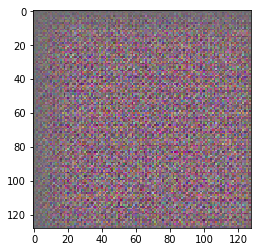

In [20]:
plt.imshow(scaled_images[0])

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[128, 128, 3]))
    
    assert model.output_shape == (None, 64, 64, 64)
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    assert model.output_shape == (None, 16, 16, 256)
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(512, (5, 5), strides=(1, 1), padding='same'))
    assert model.output_shape == (None, 16, 16, 512)
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(1024, (5, 5), strides=(2, 2), padding='same'))
    assert model.output_shape == (None, 8, 8, 1024)
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
  
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation=None))

    return model

In [22]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-7.11333e-05]], shape=(1, 1), dtype=float32)


In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [0]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [0]:
epochs = 25
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    print(f"Starting epoch: {epoch + 1}/{epochs}")
    start = time.time()
    
    step = 0
    for image_batch in dataset:
      if step % 100 == 0:
        print(f"step: {step}/{train_steps}")
      
      step += 1 
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [0]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
  
  numpy_images = predictions.numpy()
  scaled_images = (((numpy_images - numpy_images.min()) * 255) / (numpy_images.max() - numpy_images.min())).astype(np.uint8)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i + 1)
      plt.imshow(scaled_images[i])
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

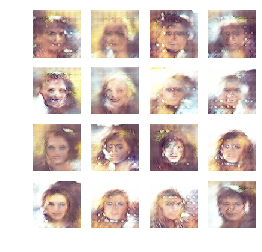

Time for epoch 13 is 3285.4593210220337 sec
Starting epoch: 14/25
step: 0/1582
step: 100/1582


In [0]:
%%time
train(dataset, epochs)

In [0]:
noise = tf.random.normal([1, noise_dim])
generated_images = generator(noise, training=False)

In [0]:
numpy_images = generated_images.numpy()
scaled_images = (((numpy_images - numpy_images.min()) * 255) / (numpy_images.max() - numpy_images.min())).astype(np.uint8)
plt.imshow(scaled_images[0])
plt.axis('off')
plt.savefig('generated image.png')
plt.show()